This notebook contains two datasets--NOAA and Era5:
*   https://www.ncei.noaa.gov/access/search/data-search/local-climatological-data-v2Links
*   https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=downloadLinks

It contains three parts -- Data preparation, Exploratory Data Analysis (Statistical comparison & visualization), and Model Development (Precipitation Prediction Models & Cloudburst Classification).

The region chosen from NOAA is the Tupelo regional airport station in Mississippi, US (USW00093862). A three-year time frame is selected, from 2019 to 2021. However, the data does not contain the second half of 2021, so it ends in June 2021, 2 and a half years in total.

Variables selected include 'hourlyprecipitation', 'hourlydewpointtemperature', 'hourlypressurechange', 'hourlyrelativehumidity', 'hourlywindspeed', 'hourlyvisibility'.


A similar region and time span are chosen from the Era5 data. Data downloaded in GRIB format.

Variables selected are much less due to the constraints of the website, collected only 10m u-component of wind, 2m temperature, Surface pressure, and Total precipitation. In addition, the temperature variable was unable to be used in later coding.

## **Part 1: Data Preparation NOAA**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive

# Load the dataset
file_path = "/content/USW00093862 station_2019_2021.csv"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv(file_path)

# Inspect the column names
print(df.columns)  # Print the actual column names in the DataFrame

# Assuming the timestamp column is named 'DATE_TIME', adjust accordingly
df['DATE_TIME'] = pd.to_datetime(df['DATE'])  # Parse the 'DATE_TIME' column to datetime

df.columns = df.columns.str.lower().str.replace(" ", "_")

# Fill NaN values using the previous period's value
df.fillna(method='ffill', inplace=True)

df['date_time'] = df['date_time'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

# Create lagged variables (3-hour lag)
df['precipitation_lag_3h'] = df['hourlyprecipitation'].shift(3)

# Convert 'T' to a numeric value (e.g., 0.0) in 'hourlyprecipitation'
df['hourlyprecipitation'] = pd.to_numeric(df['hourlyprecipitation'], errors='coerce').fillna(0.0)
#errors='coerce' will replace non-numeric values with NaN
#fillna(0.0) will replace NaN with 0.0

# Moving averages (24h and 5 days)
df['precipitation_ma_24h'] = df['hourlyprecipitation'].rolling(window=24, min_periods=1).mean()
df['precipitation_ma_5d'] = df['hourlyprecipitation'].rolling(window=5*24, min_periods=1).mean()

# Split data into training (80%) and testing (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(train_df.head())
print(test_df.head())

# Save processed files
save_path = '/content/drive/MyDrive/Practicum 2025 Spring'
train_df.to_csv(save_path + '/train_data.csv', index=False)
test_df.to_csv(save_path + '/test_data.csv', index=False)

print("Data preparation complete. Training and testing datasets saved.")


KeyboardInterrupt: 

## **Part 1 ERA5 Reanalysis Data**

In [ ]:
!pip install cfgrib
!apt-get install -y libeccodes-dev

^C


In [ ]:
import xarray as xr

# Load only the 'tp' variable by filtering on its GRIB paramId or shortName
ds_tp = xr.open_dataset(
    '/content/ebeed52e7e9541ecc82068861aafd589.grib',
    engine='cfgrib',
    backend_kwargs={'filter_by_keys': {'shortName': 'tp'}}
)

ds_tp

/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 32MB
Dimensions:     (time: 2193, step: 12, latitude: 20, longitude: 15)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 18kB 2018-12-31T18:00:00 ... 2021-12-31...
  * step        (step) timedelta64[ns] 96B 01:00:00 02:00:00 ... 12:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 160B 34.95 34.7 34.45 ... 30.7 30.45 30.2
  * longitude   (longitude) float64 120B -91.64 -91.39 -91.14 ... -88.39 -88.14
    valid_time  (time, step) datetime64[ns] 211kB ...
Data variables:
    tp          (time, step, latitude, longitude) float32 32MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-03T16:08 GRIB to CDM+CF via cfgrib-0.9.1...

(array([7.747767e+06, 1.102620e+05, 2.297800e+04, 6.491000e+03,
        2.188000e+03, 8.530000e+02, 4.030000e+02, 1.650000e+02,
        6.600000e+01, 2.700000e+01]),
 array([0.        , 0.00259938, 0.00519875, 0.00779813, 0.01039751,
        0.01299689, 0.01559626, 0.01819564, 0.02079502, 0.0233944 ,
        0.02599377]),
 <BarContainer object of 10 artists>)

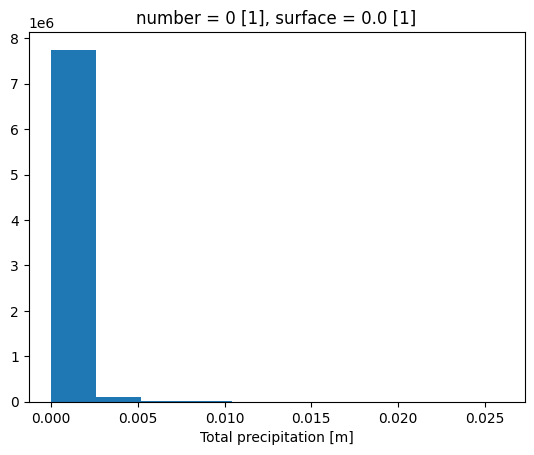

In [ ]:
ds_tp['tp'].plot()

In [ ]:
ds_temp = xr.open_dataset(
    '/content/ebeed52e7e9541ecc82068861aafd589.grib',
    engine='cfgrib',
    backend_kwargs={'filter_by_keys': {'shortName': 't2m'}}  # 2m temperature
)

ds_sp = xr.open_dataset(
    '/content/ebeed52e7e9541ecc82068861aafd589.grib',
    engine='cfgrib',
    backend_kwargs={'filter_by_keys': {'shortName': 'sp'}}  # Surface pressure
)

ds_wind = xr.open_dataset(
    '/content/ebeed52e7e9541ecc82068861aafd589.grib',
    engine='cfgrib',
    backend_kwargs={'filter_by_keys': {'shortName': '10u'}}  # 10m u-component of wind
)


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [ ]:
datasets = [ds_tp, ds_temp, ds_sp, ds_wind]
cleaned_datasets = [ds.drop_vars('valid_time', errors='ignore') for ds in datasets]

ds = xr.merge(cleaned_datasets)

In [ ]:
print(ds_tp.dims)
print(ds_tp.coords)

FrozenMappingWarningOnValuesAccess({'time': 2193, 'step': 12, 'latitude': 20, 'longitude': 15})
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 18kB 2018-12-31T18:00:00 ... 2021-12-31...
  * step        (step) timedelta64[ns] 96B 01:00:00 02:00:00 ... 12:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 160B 34.95 34.7 34.45 ... 30.7 30.45 30.2
  * longitude   (longitude) float64 120B -91.64 -91.39 -91.14 ... -88.39 -88.14
    valid_time  (time, step) datetime64[ns] 211kB ...


In [ ]:
ds.variables

Frozen({'time': <xarray.IndexVariable 'time' (time: 26305)> Size: 210kB
array(['2018-12-31T18:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-01-01T01:00:00.000000000', ..., '2021-12-31T21:00:00.000000000',
       '2021-12-31T22:00:00.000000000', '2021-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time, 'step': <xarray.IndexVariable 'step' (step: 12)> Size: 96B
array([ 3600000000000,  7200000000000, 10800000000000, 14400000000000,
       18000000000000, 21600000000000, 25200000000000, 28800000000000,
       32400000000000, 36000000000000, 39600000000000, 43200000000000],
      dtype='timedelta64[ns]')
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 20)> Size: 160B
array([34.95, 34.7 , 34.45, 34.2 , 33.95, 33.7 , 33.45, 33.2 , 32.95, 32.7 ,
       32.45, 

In [ ]:
# Pick central coordinates
lat = 32.6
lon = -89.9

# Use correct variable names from your dataset
tp_point = ds_tp['tp'].sel(latitude=lat, longitude=lon, method='nearest')
sp_point = ds_sp['sp'].sel(latitude=lat, longitude=lon, method='nearest')
wind_point = ds_wind['u10'].sel(latitude=lat, longitude=lon, method='nearest')

In [ ]:
# Convert to DataFrame and rename variables to match NOAA dataset
df_tp = tp_point.to_dataframe().rename(columns={'tp': 'hourlyprecipitation'})
df_sp = sp_point.to_dataframe().rename(columns={'sp': 'hourlypressurechange'})
df_wind = wind_point.to_dataframe().rename(columns={'u10': 'hourlywindspeed'})

In [ ]:
# Merge into one DataFrame
import pandas as pd
df_era5 = pd.concat([df_tp, df_sp, df_wind], axis=1)
df_era5 = df_era5.reset_index()

In [ ]:
df_era5.describe()

,number,surface,latitude,longitude,date_time,hourlyprecipitation,number,step,surface,latitude,longitude,date_time,hourlypressurechange,number,step,surface,latitude,longitude,date_time,hourlywindspeed
count,26316.0,26316.0,2.631600e+04,2.631600e+04,26316,26304.000000,26304.0,26304,26304.0,2.630400e+04,2.630400e+04,26304,26304.000000,26304.0,26304,26304.0,2.630400e+04,2.630400e+04,26304,26304.000000
mean,0.0,0.0,3.270000e+01,-8.989000e+01,2020-07-02 00:30:00,0.000184,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2020-07-01 23:30:00,100602.312500,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2020-07-01 23:30:00,-0.091612
min,0.0,0.0,3.270000e+01,-8.989000e+01,2018-12-31 19:00:00,0.000000,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2019-01-01 00:00:00,98597.312500,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2019-01-01 00:00:00,-9.017850
25%,0.0,0.0,3.270000e+01,-8.989000e+01,2019-10-01 21:45:00,0.000000,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2019-10-01 23:45:00,100268.296875,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2019-10-01 23:45:00,-1.356771
50%,0.0,0.0,3.270000e+01,-8.989000e+01,2020-07-02 00:30:00,0.000000,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2020-07-01 23:30:00,100560.500000,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2020-07-01 23:30:00,-0.163965
75%,0.0,0.0,3.270000e+01,-8.989000e+01,2021-04-02 03:15:00,0.000017,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2021-04-01 23:15:00,100909.867188,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2021-04-01 23:15:00,1.105096
max,0.0,0.0,3.270000e+01,-8.989000e+01,2022-01-01 06:00:00,0.023002,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2021-12-31 23:00:00,102535.281250,0.0,0 days 00:00:00,0.0,3.270000e+01,-8.989000e+01,2021-12-31 23:00:00,8.324432
std,0.0,0.0,1.319503e-11,2.522475e-11,NaN,0.000742,0.0,0 days 00:00:00,0.0,1.317371e-11,2.529580e-11,NaN,522.957764,0.0,0 days 00:00:00,0.0,1.317371e-11,2.529580e-11,NaN,1.812129


In [ ]:
# Drop duplicates
df_era5 = df_era5.drop_duplicates(subset=['date_time'])
print(df_era5.columns)

df_era5 = df_era5.drop_duplicates(subset='date_time', keep='first')

# Create 3h lagged predictors
df_era5['hourlypressurechange_lag3'] = df_era5['hourlypressurechange'].shift(3)
df_era5['hourlywindspeed_lag3'] = df_era5['hourlywindspeed'].shift(3)

# Create 3h forward precipitation
df_era5['hourlyprecipitation_lag_3h'] = df_era5['hourlyprecipitation'].shift(-3)

Index(['index', 'number', 'surface', 'latitude', 'longitude', 'date_time',
       'hourlyprecipitation', 'number', 'step', 'surface', 'latitude',
       'longitude', 'date_time', 'hourlypressurechange', 'number', 'step',
       'surface', 'latitude', 'longitude', 'date_time', 'hourlywindspeed',
       'hourlypressurechange_lag3', 'hourlywindspeed_lag3',
       'hourlyprecipitation_lag_3h'],
      dtype='object')


In [ ]:
# 5-day (120h) moving average for hourly precipitation
df_era5['precipitation_ma_5d'] = df_era5['hourlyprecipitation'].rolling(window=120, min_periods=1).mean()

# 24-hour (24h) moving average
df_era5['precipitation_ma_24h'] = df_era5['hourlyprecipitation'].rolling(window=24, min_periods=1).mean()

In [ ]:
df_era5['hourlyprecipitation'] = df_era5['hourlyprecipitation'] * 1000

df_era5['cloudburst_indicator'] = (df_era5['hourlyprecipitation'] >= 100).astype(int)

In [ ]:
# Split data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_era5, test_size=0.2, random_state=42, shuffle=False)

print(train_df.head())
print(test_df.head())

# Save processed files
save_path = '/content/drive/MyDrive/Practicum 2025 Spring'
train_df.to_csv(save_path + '/train_data_era5.csv', index=False)
test_df.to_csv(save_path + '/test_data_era5.csv', index=False)

                                    index  number  surface  latitude  \
0  (2018-12-31 18:00:00, 0 days 01:00:00)     0.0      0.0      32.7   
1  (2018-12-31 18:00:00, 0 days 02:00:00)     0.0      0.0      32.7   
2  (2018-12-31 18:00:00, 0 days 03:00:00)     0.0      0.0      32.7   
3  (2018-12-31 18:00:00, 0 days 04:00:00)     0.0      0.0      32.7   
4  (2018-12-31 18:00:00, 0 days 05:00:00)     0.0      0.0      32.7   

   longitude           date_time  hourlyprecipitation  number step  surface  \
0     -89.89 2018-12-31 19:00:00                  NaN     NaN  NaT      NaN   
1     -89.89 2018-12-31 20:00:00                  NaN     NaN  NaT      NaN   
2     -89.89 2018-12-31 21:00:00                  NaN     NaN  NaT      NaN   
3     -89.89 2018-12-31 22:00:00                  NaN     NaN  NaT      NaN   
4     -89.89 2018-12-31 23:00:00                  NaN     NaN  NaT      NaN   

   ...  latitude  longitude date_time  hourlywindspeed  \
0  ...       NaN        NaN       

## **Part 2 NOAA**

a. Compare the distributions of hourly precipitation, pressure, and temperature

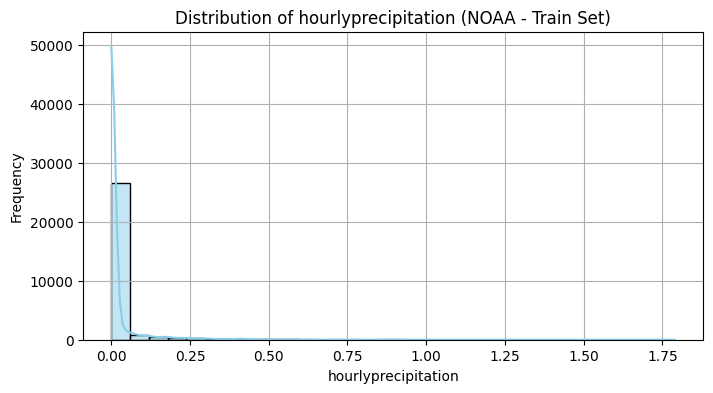

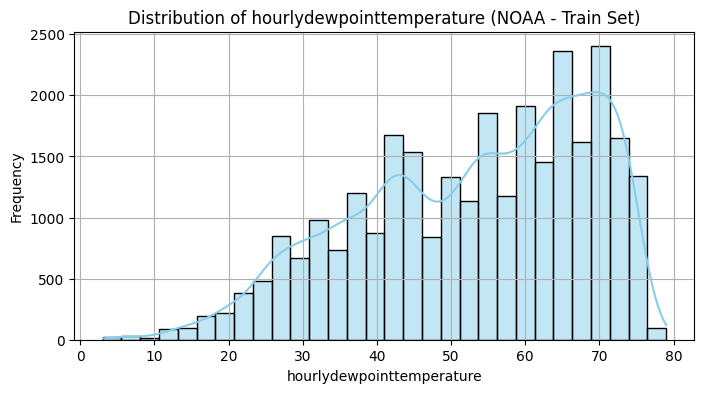

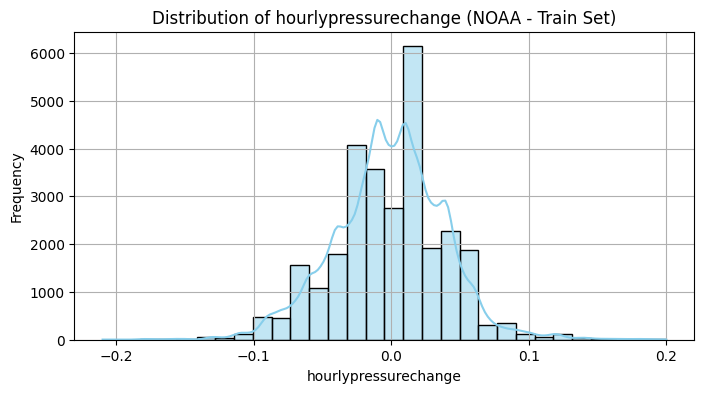

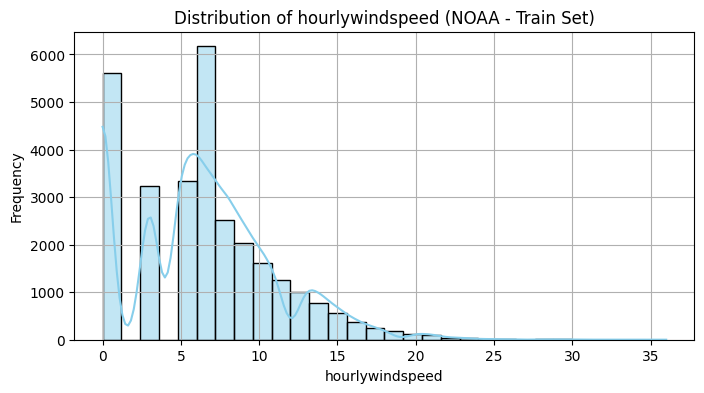

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

key_vars = ['hourlyprecipitation', 'hourlydewpointtemperature', 'hourlypressurechange', 'hourlywindspeed']

for var in key_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[var], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {var} (NOAA - Train Set)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

b. Calculate and visualize correlation matrices for each dataset

In [ ]:
# Correlation matrix for variables
# List of columns you want to make sure are numeric
vars_to_check = [
    'hourlyprecipitation', 'hourlydewpointtemperature', 'hourlypressurechange', 'hourlyrelativehumidity',
                 'hourlywindspeed', 'hourlyvisibility', 'precipitation_ma_24h', 'precipitation_ma_5d', 'precipitation_lag_3h'
]

# Convert each to numeric, coercing errors to NaN
for col in vars_to_check:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

In [ ]:
for col in vars_to_check:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

<ipython-input-97-1fd9a8ec4335>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mean(), inplace=True)


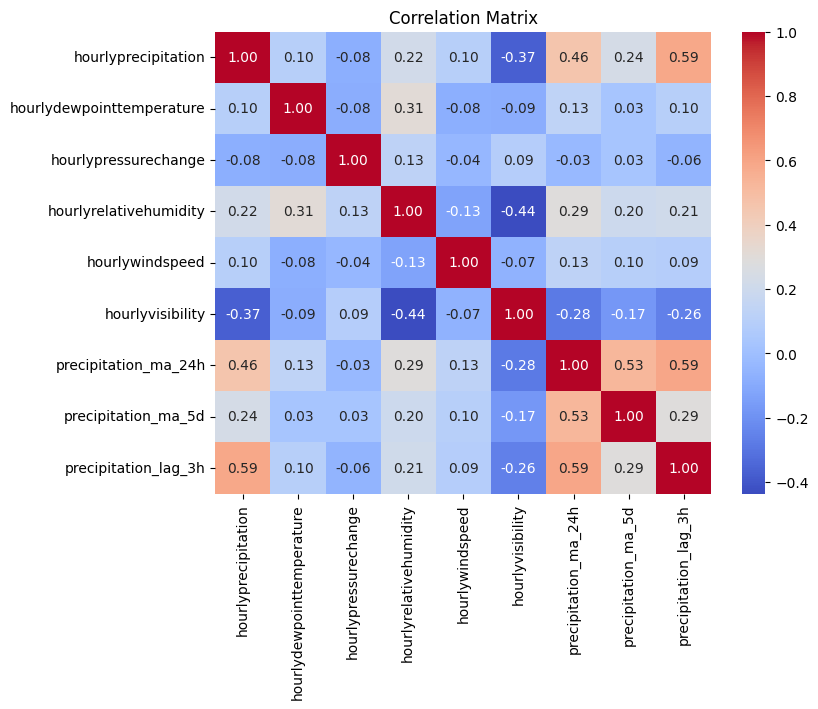

In [ ]:
corr = train_df[vars_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

c. Check temporal patterns in precipitation – are there seasonal effects?

In [ ]:
# Ensure date_time is datetime type
train_df['date_time'] = pd.to_datetime(train_df['date_time'])

# Create 'month' column
train_df['month'] = train_df['date_time'].dt.month

In [ ]:
# Group and calculate monthly averages
monthly_precip = train_df.groupby('month')[[
    'hourlyprecipitation',
    'precipitation_lag_3h',
    'precipitation_ma_24h',
    'precipitation_ma_5d'
]].mean()

<Figure size 1000x500 with 0 Axes>

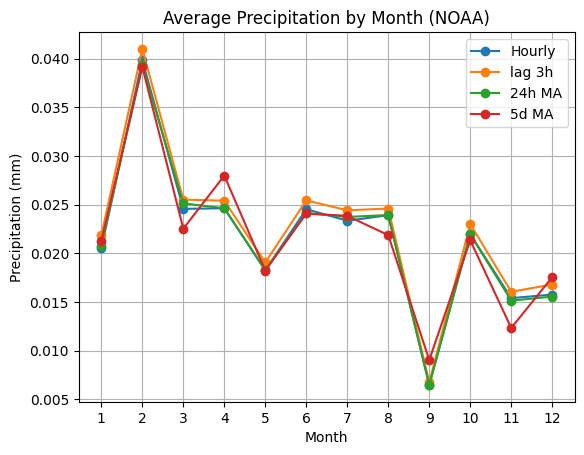

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
monthly_precip.plot(kind='line', marker='o')
plt.title('Average Precipitation by Month (NOAA)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.legend(['Hourly', 'lag 3h', '24h MA', '5d MA'])
plt.xticks(ticks=range(1, 13))
plt.show()

In [ ]:
# Extract year and month
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month

# Group by year and month, calculate averages
monthly_yearly_avg = train_df.groupby(['year', 'month'])[
    ['hourlyprecipitation', 'precipitation_lag_3h', 'precipitation_ma_24h', 'precipitation_ma_5d']
].mean().reset_index()

monthly_yearly_avg = monthly_yearly_avg[monthly_yearly_avg['year'] >= 2019]

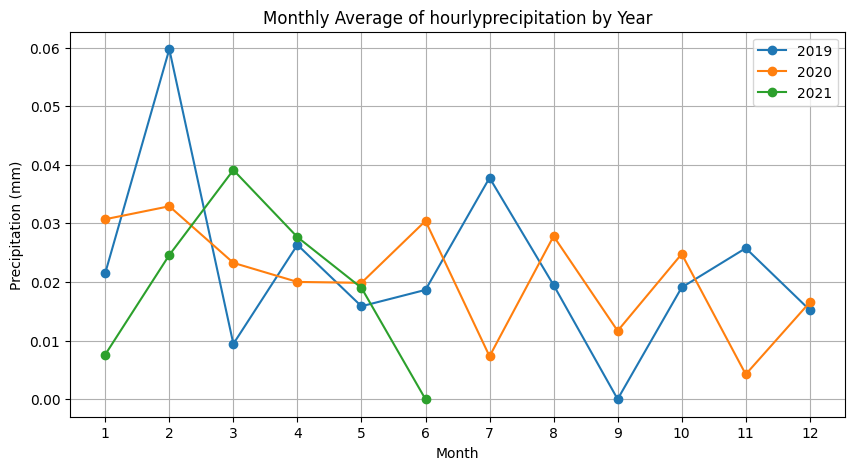

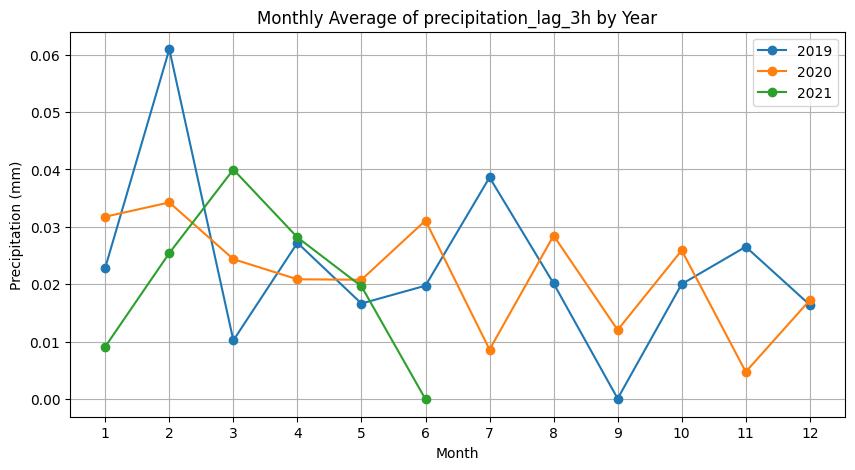

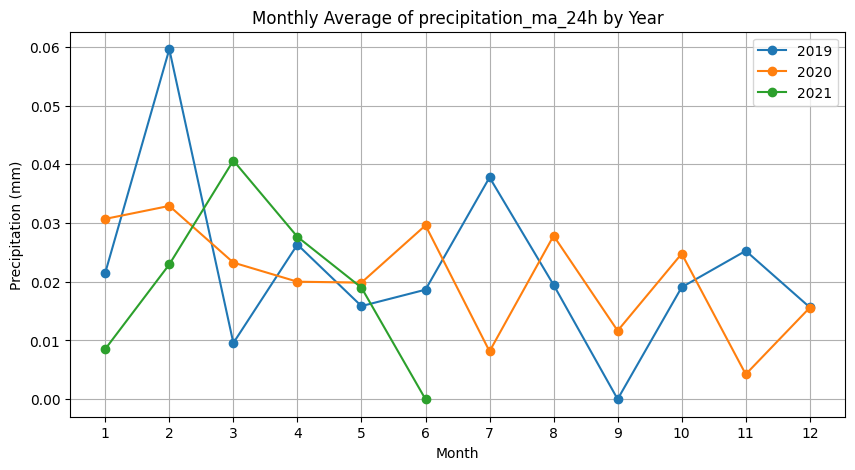

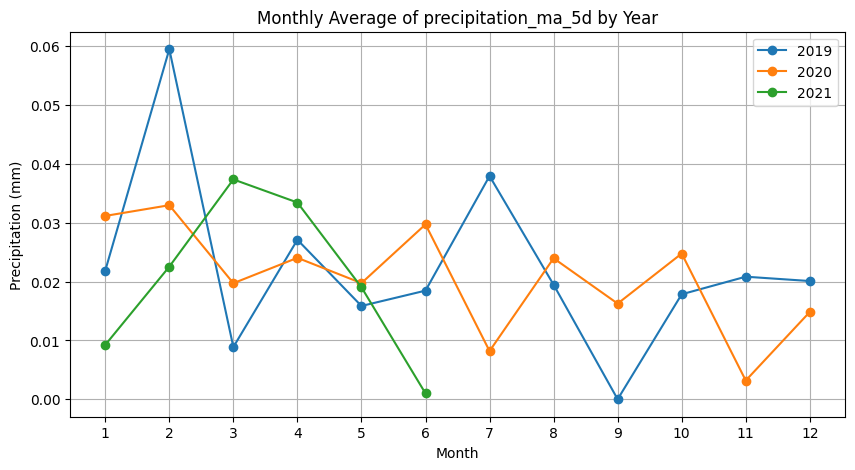

In [ ]:
# Plot each precipitation type by year
import matplotlib.pyplot as plt

for col in ['hourlyprecipitation', 'precipitation_lag_3h', 'precipitation_ma_24h', 'precipitation_ma_5d']:
    plt.figure(figsize=(10, 5))
    for year in monthly_yearly_avg['year'].unique():
        subset = monthly_yearly_avg[monthly_yearly_avg['year'] == year]
        plt.plot(subset['month'], subset[col], marker='o', label=str(year))
    plt.title(f'Monthly Average of {col} by Year')
    plt.xlabel('Month')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Filter 2021 rows
df_2021 = train_df[train_df['year'] == 2021]

# Show earliest and latest timestamps
print("2021 range:", df_2021['date_time'].min(), "to", df_2021['date_time'].max())

2021 range: 2021-01-01 00:53:00-06:00 to 2021-06-01 02:53:00-05:00


###**Visualization**


*   Create basic time series visualizations of precipitation in both datasets

*   Visualize the relationship between precipitation and potential predictor variables


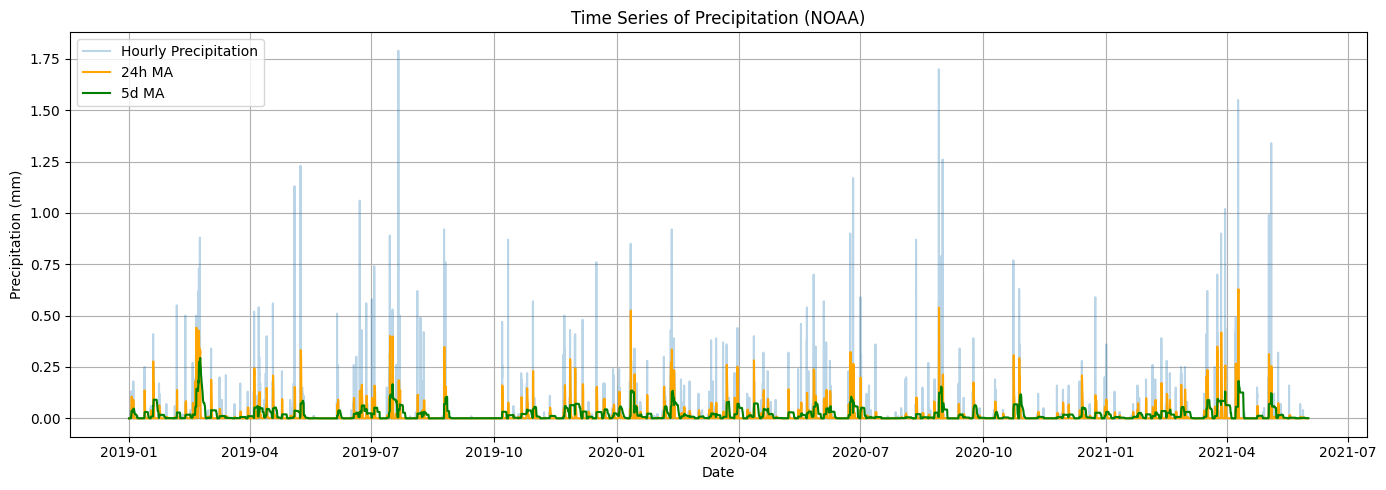

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(train_df['date_time'], train_df['hourlyprecipitation'], alpha=0.3, label='Hourly Precipitation')
plt.plot(train_df['date_time'], train_df['precipitation_ma_24h'], label='24h MA', color='orange')
plt.plot(train_df['date_time'], train_df['precipitation_ma_5d'], label='5d MA', color='green')
plt.title('Time Series of Precipitation (NOAA)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
predictors = [
    'hourlydewpointtemperature',
    'hourlypressurechange',
    'hourlyrelativehumidity',
    'hourlywindspeed',
    'hourlyvisibility'
]

In [ ]:
for var in predictors:
    corr = train_df['hourlyprecipitation'].corr(train_df[var])
    print(f"{var}: correlation = {corr:.2f}")

hourlydewpointtemperature: correlation = 0.10
hourlypressurechange: correlation = -0.08
hourlyrelativehumidity: correlation = 0.22
hourlywindspeed: correlation = 0.10
hourlyvisibility: correlation = -0.37


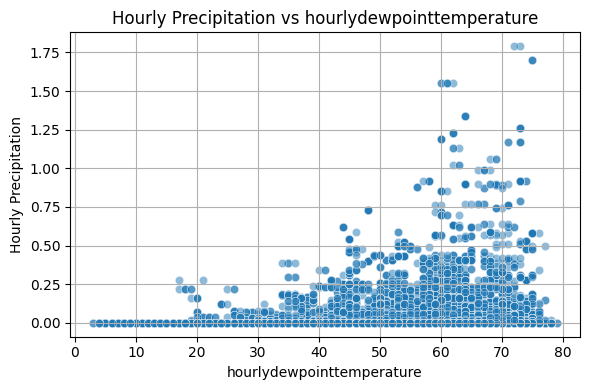

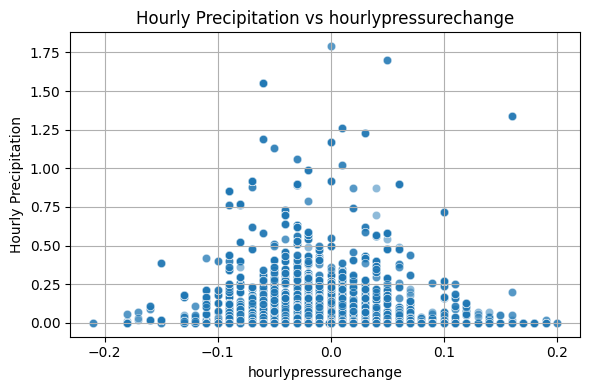

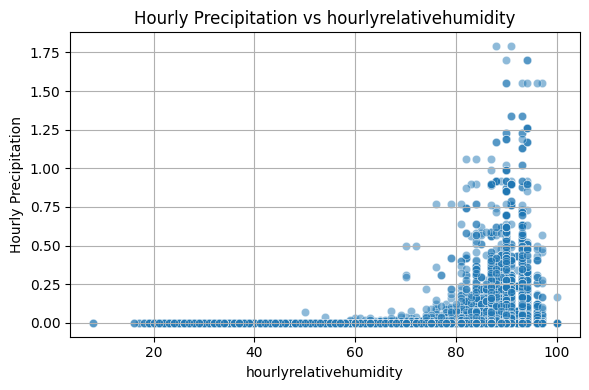

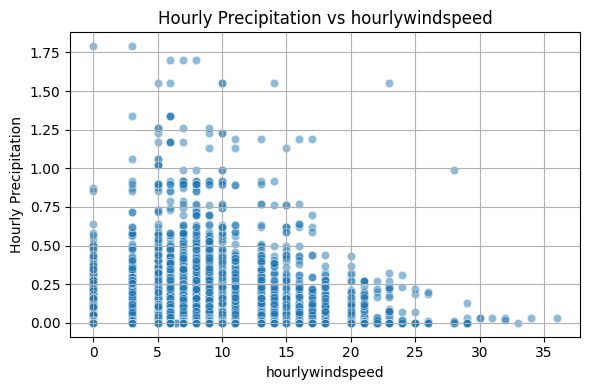

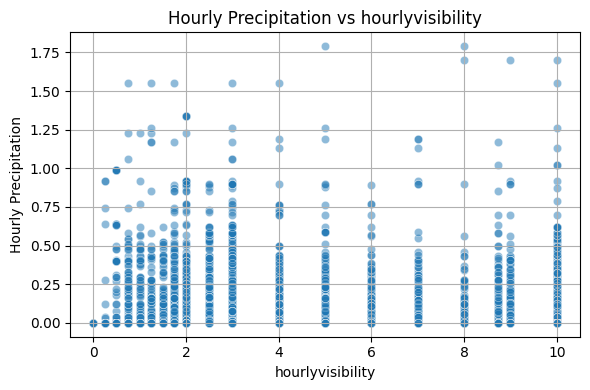

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train_df, x=var, y='hourlyprecipitation', alpha=0.5)
    plt.title(f'Hourly Precipitation vs {var}')
    plt.xlabel(var)
    plt.ylabel('Hourly Precipitation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Part 2: Era5 dataset**

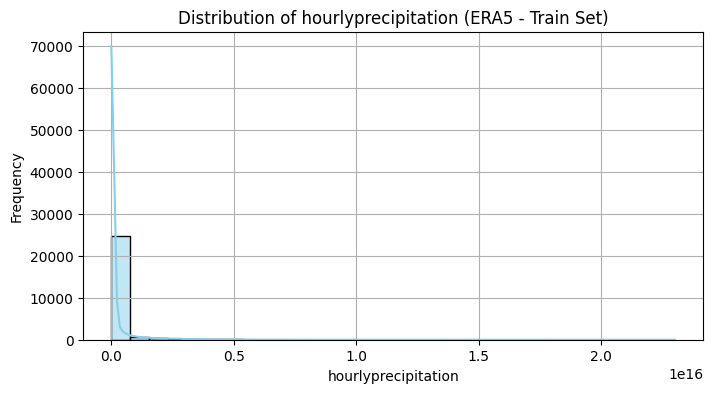

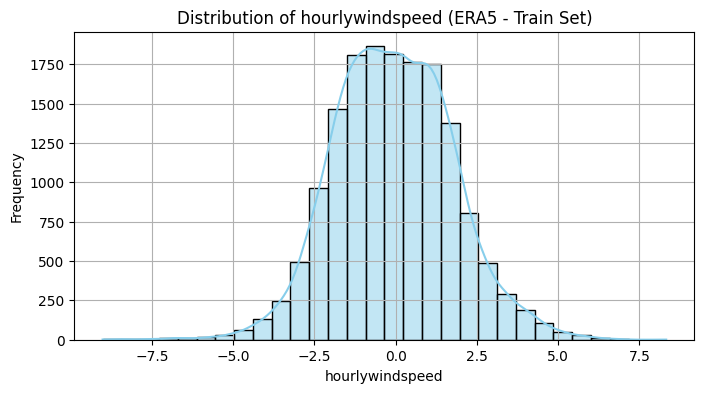

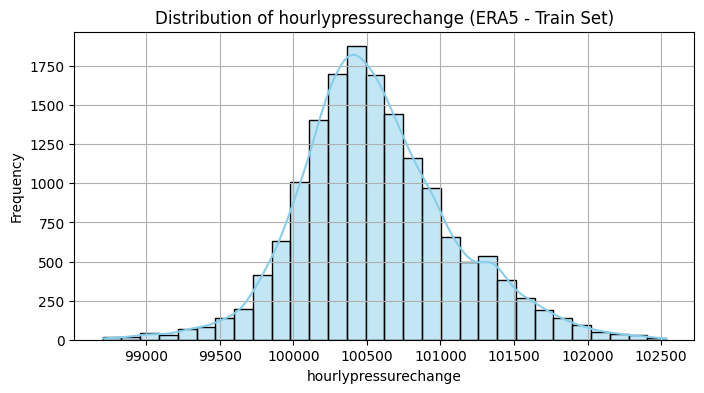

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

key_vars = ['hourlyprecipitation', 'hourlywindspeed', 'hourlypressurechange']

for var in key_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[var], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {var} (ERA5 - Train Set)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Correlation matrix for variables
# List of columns you want to make sure are numeric
vars_to_check = [
    'hourlyprecipitation', 'hourlypressurechange',
   'hourlywindspeed', 'precipitation_ma_24h', 'precipitation_ma_5d', 'hourlyprecipitation_lag_3h'
]

# Convert each to numeric, coercing errors to NaN
for col in vars_to_check:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

In [ ]:
for col in vars_to_check:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

<ipython-input-77-1fd9a8ec4335>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mean(), inplace=True)


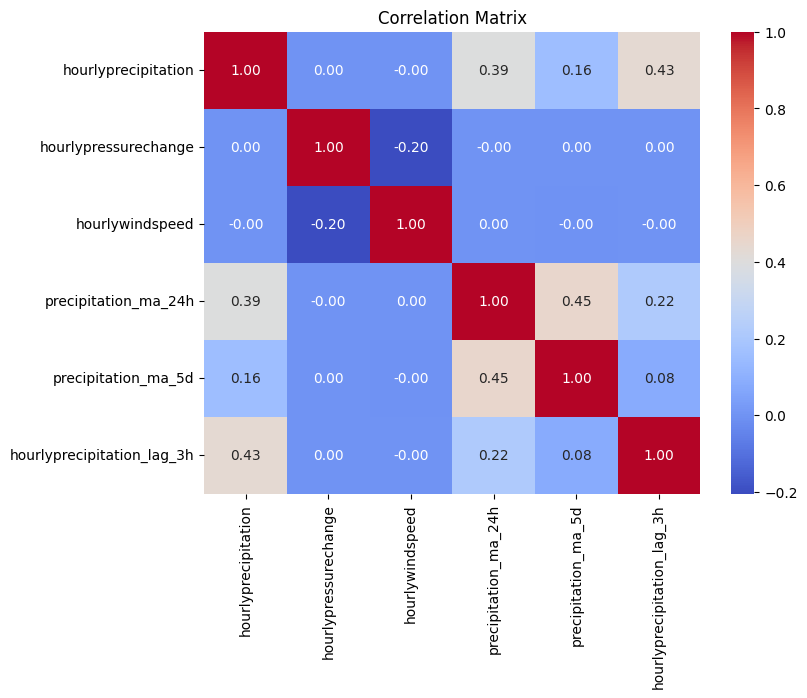

In [ ]:
corr = train_df[vars_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Ensure date_time is datetime type
# Check for duplicate columns:
print(train_df.columns[train_df.columns.duplicated()])

# If duplicates are found, consider renaming or dropping them:
# Example if 'date_time' is duplicated:
train_df = train_df.loc[:, ~train_df.columns.duplicated()]  # Keep first instance of duplicated columns

# After fixing duplicates, then try converting to datetime:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
# Create 'month' column
train_df['month'] = train_df['date_time'].dt.month

Index(['number', 'surface', 'latitude', 'longitude', 'date_time', 'number',
       'step', 'surface', 'latitude', 'longitude', 'date_time'],
      dtype='object')


<ipython-input-80-b89101c9ed76>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date_time'] = pd.to_datetime(train_df['date_time'])
<ipython-input-80-b89101c9ed76>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df['date_time'].dt.month


In [ ]:
# Group and calculate monthly averages
monthly_precip = train_df.groupby('month')[[
    'hourlyprecipitation',
    'hourlyprecipitation_lag_3h',
    'precipitation_ma_24h',
    'precipitation_ma_5d'
]].mean()

<Figure size 1000x500 with 0 Axes>

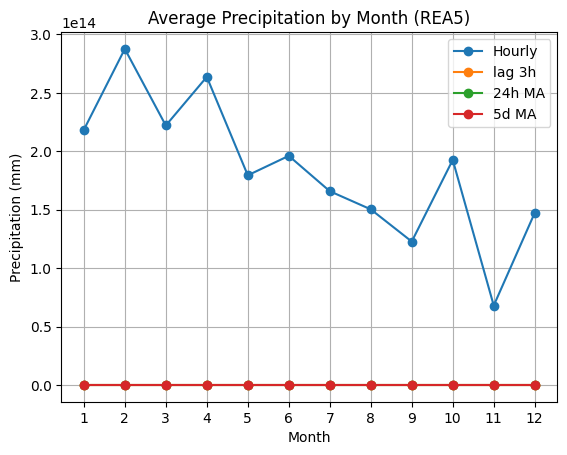

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
monthly_precip.plot(kind='line', marker='o')
plt.title('Average Precipitation by Month (REA5)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.legend(['Hourly', 'lag 3h', '24h MA', '5d MA'])
plt.xticks(ticks=range(1, 13))
plt.show()

### Visualization

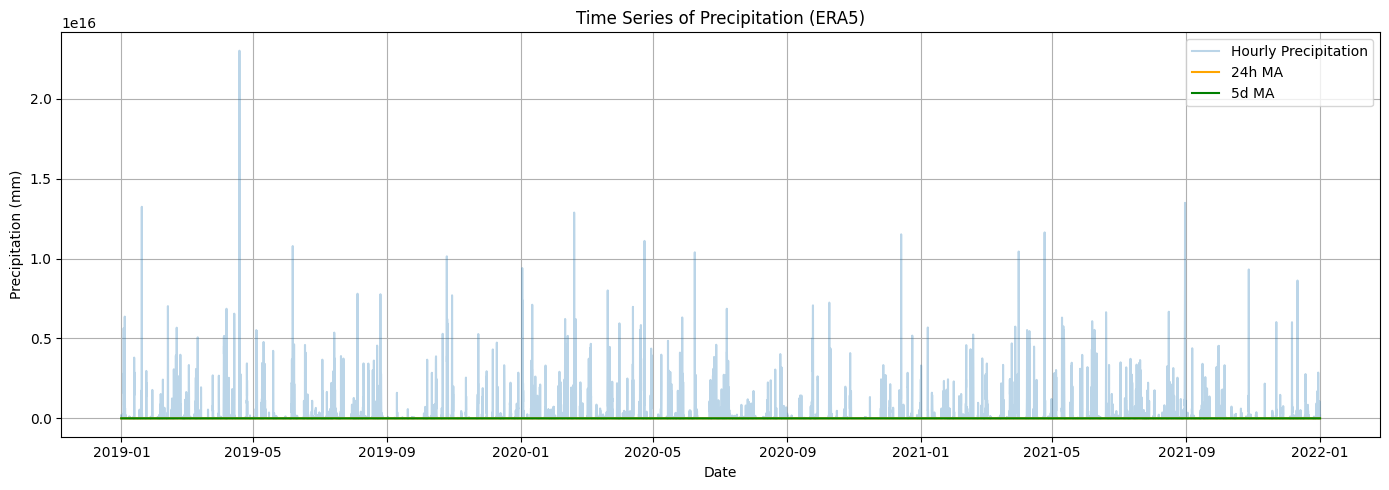

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(train_df['date_time'], train_df['hourlyprecipitation'], alpha=0.3, label='Hourly Precipitation')
plt.plot(train_df['date_time'], train_df['precipitation_ma_24h'], label='24h MA', color='orange')
plt.plot(train_df['date_time'], train_df['precipitation_ma_5d'], label='5d MA', color='green')
plt.title('Time Series of Precipitation (ERA5)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
predictors = [
    'hourlypressurechange',
    'hourlywindspeed',
]

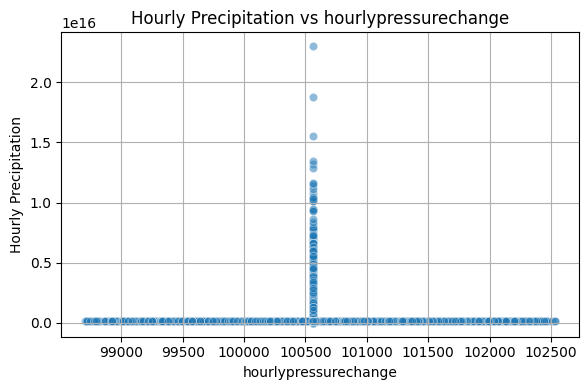

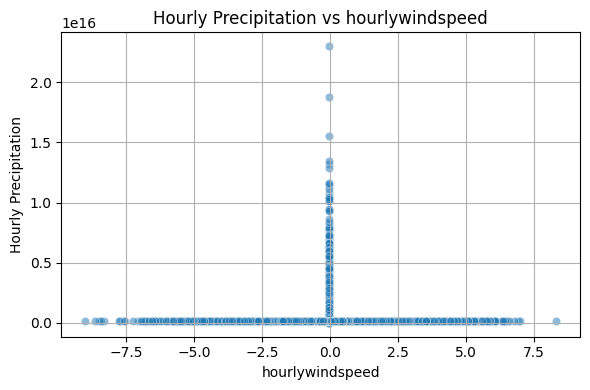

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train_df, x=var, y='hourlyprecipitation', alpha=0.5)
    plt.title(f'Hourly Precipitation vs {var}')
    plt.xlabel(var)
    plt.ylabel('Hourly Precipitation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Comparison
I found hourly precipitation to have no relationship with the hourly windspeed and hourly pressure change predictors in the Era5 dataset. Whereas the NOAA dataset shows a relatively significant correlation between precipitation and other variables. However, both data indicate that the precipitation rate rises in certain months, especially in February. They are also revealing a generally decreasing trend after February, with a steeper drop in September while a slight increase in October.  Hence, it is likely that there is a monthly or even seasonal effect.

The lack of correlation in Era5 dataset might be due to some errors not yet identified.

## **Part 3**

In [ ]:
predictors_to_lag = [
    'hourlydewpointtemperature',
    'hourlypressurechange',
    'hourlyrelativehumidity',
    'hourlywindspeed',
    'hourlyvisibility'
]

In [ ]:
for col in predictors_to_lag:
    train_df[col + '_lag3'] = train_df[col].shift(3)

In [ ]:
features = ['precipitation_lag_3h'] + [col + '_lag3' for col in predictors_to_lag]
target = 'hourlyprecipitation'

In [ ]:
# Combine X and y, drop rows with missing values
model_data = train_df[features + [target]].dropna()

X = model_data[features]
y = model_data[target]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

In [ ]:
## Multiple Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression — RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}")


Linear Regression — RMSE: 0.0801, MAE: 0.0256


In [ ]:
## Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest — RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}")


Random Forest — RMSE: 0.0826, MAE: 0.0204


In [ ]:
## 1 inch = 25.4 mm
df['hourlyprecipitation_mm'] = df['hourlyprecipitation'] * 25.4
df['cloudburst_indicator'] = (df['hourlyprecipitation_mm'] >= 100).astype(int)

cloudburst_counts = df['cloudburst_indicator'].value_counts(normalize=True) * 100
print(cloudburst_counts)

cloudburst_indicator
0    100.0
Name: proportion, dtype: float64


In [ ]:
## Try relax the 100mm threshold
# 100 to 50
df['cloudburst_indicator'] = (df['hourlyprecipitation_mm'] >= 50).astype(int)

cloudburst_counts = df['cloudburst_indicator'].value_counts(normalize=True) * 100
print(cloudburst_counts)

# 100 to 40
df['cloudburst_indicator'] = (df['hourlyprecipitation_mm'] >= 40).astype(int)

cloudburst_counts = df['cloudburst_indicator'].value_counts(normalize=True) * 100
print(cloudburst_counts)

cloudburst_indicator
0    100.0
Name: proportion, dtype: float64
cloudburst_indicator
0    99.986315
1     0.013685
Name: proportion, dtype: float64


In [ ]:
## Check when exactly this event happens
cloudburst_times = df[df['cloudburst_indicator'] == 1]['date_time'].value_counts().sort_index()
print(cloudburst_times)

date_time
2019-07-21 07:53:00-05:00    1
2019-07-21 08:01:00-05:00    1
2020-08-28 17:53:00-05:00    1
2020-08-28 18:01:00-05:00    1
2020-08-28 18:46:00-05:00    1
Name: count, dtype: int64


In [ ]:
cloudburst_times_df = cloudburst_times.reset_index()
cloudburst_times_df.columns = ['date_time', 'num_cloudbursts']
print(cloudburst_times_df.head())

                  date_time  num_cloudbursts
0 2019-07-21 07:53:00-05:00                1
1 2019-07-21 08:01:00-05:00                1
2 2020-08-28 17:53:00-05:00                1
3 2020-08-28 18:01:00-05:00                1
4 2020-08-28 18:46:00-05:00                1


In [ ]:
predictors_to_lag = [
    'hourlydewpointtemperature',
    'hourlypressurechange',
    'hourlyrelativehumidity',
    'hourlywindspeed',
    'hourlyvisibility'
]

for col in predictors_to_lag:
    df[col + '_lag3'] = df[col].shift(3)

features_A = [
    'precipitation_lag_3h',
    'hourlydewpointtemperature_lag3',
    'hourlypressurechange_lag3',
    'hourlyrelativehumidity_lag3',
    'hourlywindspeed_lag3',
    'hourlyvisibility_lag3'
]
target = 'cloudburst_indicator'

df_model = df[features_A + [target]].dropna()
# Replace 'T' with 0.0 across all relevant features
df_model.replace('T', 0.0, inplace=True)
for col in features:
    # Convert to string, remove unwanted characters, and convert to float
    df_model[col] = df_model[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0.0)

X = df_model[features]
y = df_model[target]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train and evaluate
log_model_A = LogisticRegression(max_iter=1000, random_state=42)
log_model_A.fit(X_train, y_train)

y_pred_A = log_model_A.predict(X_test)
y_proba_A = log_model_A.predict_proba(X_test)[:, 1]

print("Model A: Without precipitation_ma_5d")
print(classification_report(y_test, y_pred_A))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_A):.4f}")

Model A: Without precipitation_ma_5d
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7304
           1       0.00      0.00      0.00         2

    accuracy                           1.00      7306
   macro avg       0.50      0.50      0.50      7306
weighted avg       1.00      1.00      1.00      7306

ROC AUC: 0.9867


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Consider including local trends such as 5-day precipitation moving average in your model

In [ ]:
predictors_to_lag = [
    'hourlydewpointtemperature',
    'hourlypressurechange',
    'hourlyrelativehumidity',
    'hourlywindspeed',
    'hourlyvisibility'
]

for col in predictors_to_lag:
    df[col + '_lag3'] = df[col].shift(3)

features_B = [
    'precipitation_lag_3h',
    'hourlydewpointtemperature_lag3',
    'hourlypressurechange_lag3',
    'hourlyrelativehumidity_lag3',
    'hourlywindspeed_lag3',
    'hourlyvisibility_lag3',
    'precipitation_ma_5d'  # New predictor added
]
target = 'cloudburst_indicator'

df_model = df[features_B + [target]].dropna()

# Replace 'T' with 0.0 across all relevant features
df_model.replace('T', 0.0, inplace=True)
for col in features:
    # Convert to string, remove unwanted characters, and convert to float
    df_model[col] = df_model[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0.0)

X = df_model[features]
y = df_model[target]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train and evaluate
log_model_B = LogisticRegression(max_iter=1000, random_state=42)
log_model_B.fit(X_train, y_train)

y_pred_A = log_model_A.predict(X_test)
y_proba_A = log_model_A.predict_proba(X_test)[:, 1]

print("🔹 Model A: Without precipitation_ma_5d")
print(classification_report(y_test, y_pred_A))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_A):.4f}")

🔹 Model A: Without precipitation_ma_5d
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7304
           1       0.00      0.00      0.00         2

    accuracy                           1.00      7306
   macro avg       0.50      0.50      0.50      7306
weighted avg       1.00      1.00      1.00      7306

ROC AUC: 0.9867


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Part 3 Era5 Dataset**

In [ ]:
predictors_to_lag = [
    'hourlypressurechange',
    'hourlywindspeed',
]